## Import Libiraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

## Initial Data Inspection

In [2]:
df = pd.read_csv('heart_2020_cleaned.csv')

In [3]:
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

In [5]:
df['HeartDisease'].value_counts()

HeartDisease
No     292422
Yes     27373
Name: count, dtype: int64

## Exploratory Data Analysis

Text(0, 0.5, 'Count')

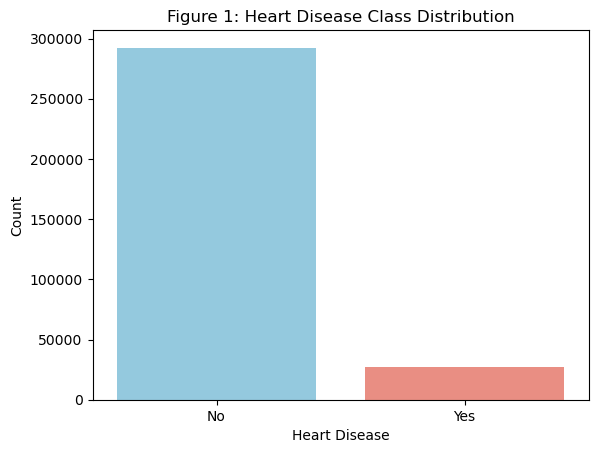

In [6]:
sns.countplot(x= 'HeartDisease', data = df, palette = ['skyblue', 'salmon'])
plt.title('Figure 1: Heart Disease Class Distribution')
plt.xlabel('Heart Disease')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

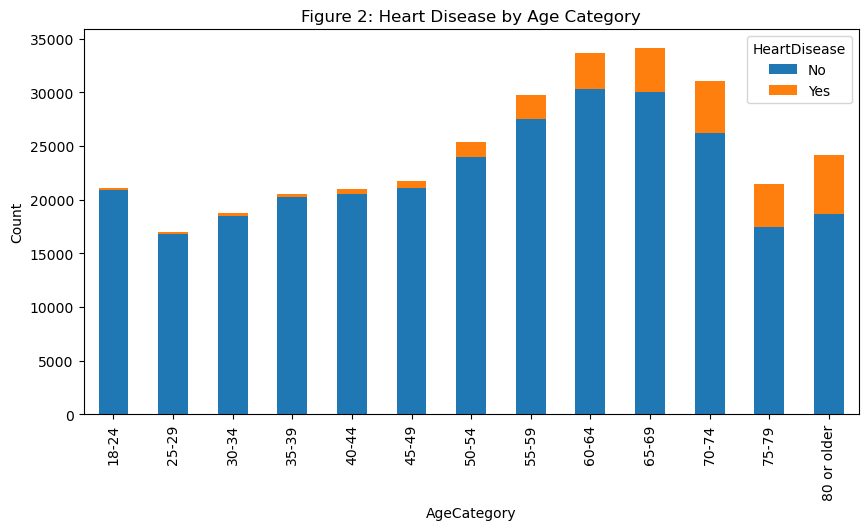

In [7]:
pd.crosstab(df['AgeCategory'], df['HeartDisease']).plot(kind='bar', stacked=True, figsize=(10,5))
plt.title('Figure 2: Heart Disease by Age Category')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

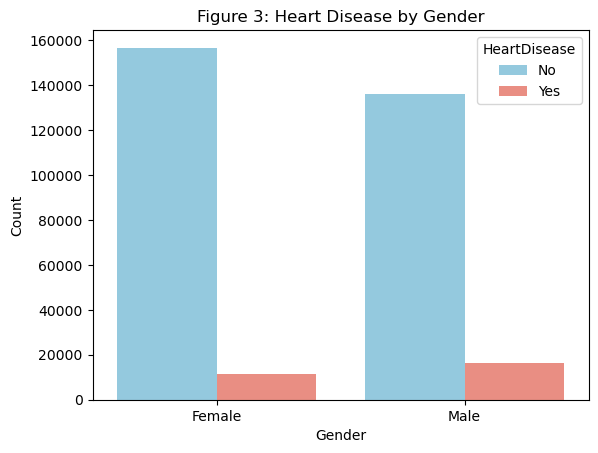

In [8]:
sns.countplot(x = 'Sex', data = df, hue = 'HeartDisease', palette=['skyblue', 'salmon'])
plt.title('Figure 3: Heart Disease by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')

Text(0.5, 1.0, 'Figure 4: Heart Disease by Smoking')

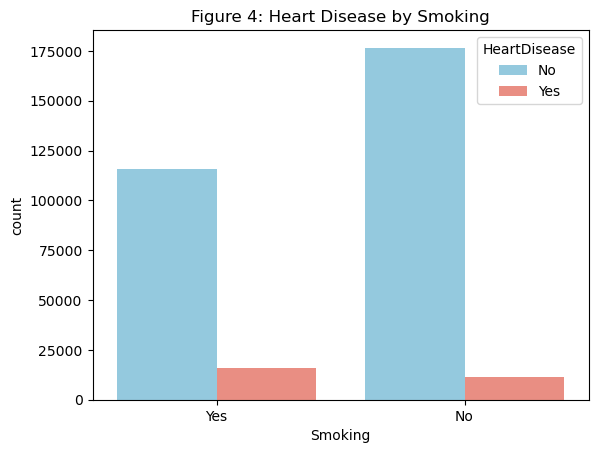

In [9]:
sns.countplot(x = 'Smoking', data = df, hue = 'HeartDisease', palette=['skyblue', 'salmon'])
plt.title('Figure 4: Heart Disease by Smoking')

Text(0.5, 1.0, 'Figure 5: Heart Disease by Alcohol Drinking')

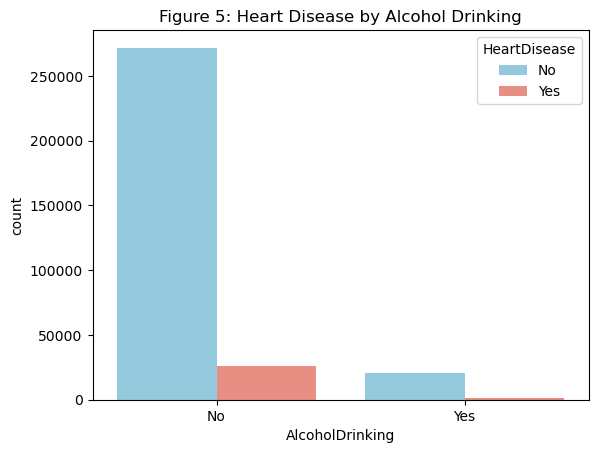

In [10]:
sns.countplot(x = 'AlcoholDrinking', data = df, hue = 'HeartDisease', palette=['skyblue', 'salmon'])
plt.title('Figure 5: Heart Disease by Alcohol Drinking')

Text(0.5, 1.0, 'Figure 6: BMI by Heart Disease Status')

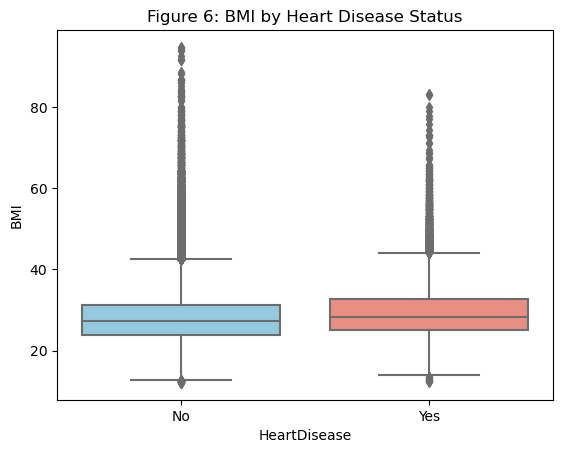

In [11]:
sns.boxplot(x='HeartDisease', y='BMI', data=df, palette = ['skyblue', 'salmon'])
plt.title('Figure 6: BMI by Heart Disease Status')


## Data Preprocessing

In [12]:
age_mapping = {
    '18-24': 0,
    '25-29': 1,
    '30-34': 2,
    '35-39': 3,
    '40-44': 4,
    '45-49': 5,
    '50-54': 6,
    '55-59': 7,
    '60-64': 8,
    '65-69': 9,
    '70-74': 10,
    '75-79': 11,
    '80 or older': 12
}
df['AgeCategory_encoded'] = df['AgeCategory'].map(age_mapping)

In [13]:
GenHealth_mapping = {
    'Poor': 0,
    'Fair': 1,
    'Good': 2,
    'Very good': 3,
    'Excellent':4
}

df['GenHealth_encoded'] = df['GenHealth'].map(GenHealth_mapping)

In [14]:
disease_mapping = {
    'No' : 0,
    'Yes': 1
}
df['HeartDisease_encoded'] = df['HeartDisease'].map(disease_mapping)

In [15]:
cat_feat = ['Smoking', 'AlcoholDrinking', 'Stroke',
       'DiffWalking', 'Sex', 'Race', 'Diabetic', 'PhysicalActivity', 
       'Asthma', 'KidneyDisease', 'SkinCancer']

df = pd.get_dummies(df, columns = cat_feat, drop_first=True)

In [16]:
df = df.drop(['AgeCategory', 'HeartDisease', 'GenHealth'], axis =1)

In [17]:
df.rename(columns={
    'Diabetic_No, borderline diabetes': 'Diabetic_No_borderline_diabetes',
    'Diabetic_Yes (during pregnancy)': 'Diabetic_Yes_during_pregnancy',
    'AgeCategory_encoded': 'AgeCategory',
    'GenHealth_encoded': 'GenHealth',
    'HeartDisease_encoded': 'HeartDisease'
}, inplace=True)

In [18]:
df.head()

,BMI,PhysicalHealth,MentalHealth,SleepTime,AgeCategory,GenHealth,HeartDisease,Smoking_Yes,AlcoholDrinking_Yes,Stroke_Yes,...,Race_Hispanic,Race_Other,Race_White,Diabetic_No_borderline_diabetes,Diabetic_Yes,Diabetic_Yes_during_pregnancy,PhysicalActivity_Yes,Asthma_Yes,KidneyDisease_Yes,SkinCancer_Yes
0,16.60,3.0,30.0,5.0,7,3,0,True,False,False,...,False,False,True,False,True,False,True,True,False,True
1,20.34,0.0,0.0,7.0,12,3,0,False,False,True,...,False,False,True,False,False,False,True,False,False,False
2,26.58,20.0,30.0,8.0,9,1,0,True,False,False,...,False,False,True,False,True,False,True,True,False,False
3,24.21,0.0,0.0,6.0,11,2,0,False,False,False,...,False,False,True,False,False,False,False,False,False,True
4,23.71,28.0,0.0,8.0,4,3,0,False,False,False,...,False,False,True,False,False,False,True,False,False,False


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 24 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   BMI                              319795 non-null  float64
 1   PhysicalHealth                   319795 non-null  float64
 2   MentalHealth                     319795 non-null  float64
 3   SleepTime                        319795 non-null  float64
 4   AgeCategory                      319795 non-null  int64  
 5   GenHealth                        319795 non-null  int64  
 6   HeartDisease                     319795 non-null  int64  
 7   Smoking_Yes                      319795 non-null  bool   
 8   AlcoholDrinking_Yes              319795 non-null  bool   
 9   Stroke_Yes                       319795 non-null  bool   
 10  DiffWalking_Yes                  319795 non-null  bool   
 11  Sex_Male                         319795 non-null  bool   
 12  Ra

## Define X and Y

In [20]:
X = df.drop('HeartDisease', axis = 1)
y = df['HeartDisease']

## Logistic Regression 

In [21]:
# 1. Set global randomness seeds
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# 2. Define model
model = LogisticRegression(
    class_weight={0: 1, 1: 10},    
    solver='saga',
    max_iter=1000,
    random_state=RANDOM_STATE
)

# 3. Build pipeline
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),                   
    ('smote', SMOTE(random_state=RANDOM_STATE)),     
    ('model', model)
])

# 4. Stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# 5. Cross-validated predicted probabilities
y_probs_lr = cross_val_predict(
    pipeline_lr, X, y,
    cv=cv,
    method='predict_proba',
    n_jobs=-1
)[:, 1]

# 6. Threshold tuning based on F1-score
precision, recall, thresholds = precision_recall_curve(y, y_probs_lr)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
optimal_threshold = thresholds[np.argmax(f1_scores)]

# 7. Final prediction using optimal threshold
y_pred = (y_probs_lr >= optimal_threshold).astype(int)

# 8. Evaluation
print("Logistic Regression Results")
print("Optimal Threshold:", round(optimal_threshold, 3))
print("\nClassification Report:\n", classification_report(y, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y, y_pred))
print("ROC-AUC Score:", roc_auc_score(y, y_probs_lr))

/Users/pyaekyitharchaw/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/pyaekyitharchaw/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/pyaekyitharchaw/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression Results
Optimal Threshold: 0.961

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.89      0.92    292422
           1       0.31      0.53      0.39     27373

    accuracy                           0.86    319795
   macro avg       0.63      0.71      0.66    319795
weighted avg       0.90      0.86      0.88    319795

Confusion Matrix:
 [[260669  31753]
 [ 12856  14517]]
ROC-AUC Score: 0.8394750861204269


## XGBClassifier 

In [22]:
# 1. Set global randomness
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# 2. Define model
model_xgb = XGBClassifier(
    scale_pos_weight=5,       
    max_depth=5,            
    learning_rate=0.1,        
    n_estimators=300,        
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,                  
    reg_alpha=0.1,           
    reg_lambda=1.0,           
    eval_metric='aucpr',      
    use_label_encoder=False,
    random_state=RANDOM_STATE
)

# 3. Build pipeline 
pipeline_xgb = Pipeline([
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('model', model_xgb)
])

# 4. Stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# 5. Cross-validated predicted probabilities
y_probs_xgb = cross_val_predict(
    pipeline_xgb,
    X, y,
    cv=cv,
    method='predict_proba',
    n_jobs=-1,
    verbose=0
)[:, 1]

# 6. Threshold tuning based on F1-score
precision, recall, thresholds = precision_recall_curve(y, y_probs_xgb)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
optimal_threshold = thresholds[np.argmax(f1_scores)]

# 7. Final prediction using optimal threshold
y_pred_xgb = (y_probs_xgb >= optimal_threshold).astype(int)

# 8. Evaluation
print("XGBoost Results")
print("\nOptimal Threshold:", round(optimal_threshold, 3))
print("\nClassification Report:\n", classification_report(y, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y, y_pred_xgb))
print("ROC-AUC Score:", roc_auc_score(y, y_probs_xgb))


/Users/pyaekyitharchaw/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:01:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/pyaekyitharchaw/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:01:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/pyaekyitharchaw/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:01:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/pyaekyitharchaw/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:01:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters:

XGBoost Results

Optimal Threshold: 0.849

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.89      0.92    292422
           1       0.29      0.48      0.36     27373

    accuracy                           0.85    319795
   macro avg       0.62      0.68      0.64    319795
weighted avg       0.89      0.85      0.87    319795

Confusion Matrix:
 [[260332  32090]
 [ 14322  13051]]
ROC-AUC Score: 0.8169362852422114


## Random Forest

In [23]:
# 1. Set global random seed
np.random.seed(42)
RANDOM_STATE = 42

# 2. Define model
model_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=3,
    class_weight='balanced_subsample',
    random_state=RANDOM_STATE,
    n_jobs=-1
)


# 3. Build pipeline
pipeline_rf = Pipeline([
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('model', model_rf)
])


# 4. Stratified 5-fold cross-validation
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_STATE       
)

# 5. Cross-validated predicted probabilities
y_probs_rf = cross_val_predict(
    pipeline_rf,
    X, y,
    cv=cv,
    method='predict_proba',
    n_jobs=-1,                      
    verbose=1                       
)[:, 1]

# 6. Threshold tuning based on F1-score
precision, recall, thresholds = precision_recall_curve(y, y_probs_rf)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
optimal_threshold = thresholds[np.argmax(f1_scores)]

# 7. Final prediction using optimal threshold
y_pred = (y_probs_rf >= optimal_threshold).astype(int)

# 8. Evaluation
print("Random Forest Results")
print("\nOptimal Threshold:", round(optimal_threshold, 3))
print("\nClassification Report:")
print(classification_report(y, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))
print("ROC-AUC Score:", roc_auc_score(y, y_probs_rf))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.5min remaining:  3.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished


Random Forest Results

Optimal Threshold: 0.598

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.88      0.92    292422
           1       0.29      0.51      0.37     27373

    accuracy                           0.85    319795
   macro avg       0.62      0.69      0.64    319795
weighted avg       0.89      0.85      0.87    319795

Confusion Matrix:
[[258072  34350]
 [ 13529  13844]]
ROC-AUC Score: 0.823869896585097


## Precision-Recall Curve Comparison

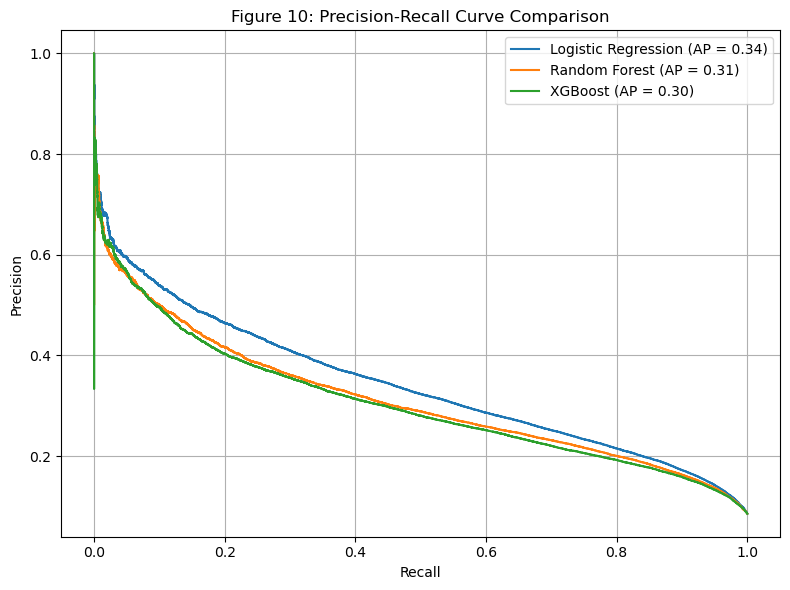

In [24]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Calculate precision-recall points
precision_lr, recall_lr, _ = precision_recall_curve(y, y_probs_lr)
precision_rf, recall_rf, _ = precision_recall_curve(y, y_probs_rf)
precision_xgb, recall_xgb, _ = precision_recall_curve(y, y_probs_xgb)

# Average precision scores for the legend
ap_lr = average_precision_score(y, y_probs_lr)
ap_rf = average_precision_score(y, y_probs_rf)
ap_xgb = average_precision_score(y, y_probs_xgb)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall_lr, precision_lr, label=f'Logistic Regression (AP = {ap_lr:.2f})')
plt.plot(recall_rf, precision_rf, label=f'Random Forest (AP = {ap_rf:.2f})')
plt.plot(recall_xgb, precision_xgb, label=f'XGBoost (AP = {ap_xgb:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Figure 10: Precision-Recall Curve Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()